# Fitting the complete kinetics against a full set of traces
Since the goodness of fit with the hand-fitted kinetics (see Kv14x-fitting-failure) is rather appalling, I'm trying something else: Fitting the whole shebang, all 31 parameters of the two-component model, against a full set of traces, in one go. The fit will take ages, which is why I'm using only a single recording for now, but I hope I'll learn something from it.

In [1]:
%load_ext autoreload
%autoreload 1

%aimport analysis_helpers
%aimport Kv14

import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import analysis_helpers as ah
import time

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
ana = [
    Kv14.Analysis('/home/kernfel/Documents/Data/Oocytes/2017_12_06_%04d.atf', (36,37,None,39))
]

In [3]:
for a in ana:
    a.fit()

analysis_helpers.py:123: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:123: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


Trace 8 truncated fast tau 12.39594796487387


In [4]:
for i,a in enumerate(ana):
    print '%d (%s):\n%s\n' % (i, a.paramsfile, a.params_str())

0 (/home/kernfel/Documents/Data/Oocytes/2017_12_06_0039.params):
gl:	1.947927 μS
El:	-7.357096 mV
gA:	84.084359 μS
EK:	-80.001965 mV
C:	176.326881 nF




In [16]:
pA = np.concatenate(((-80., 0.022, 0.092),
                     Kv14.nsA, Kv14.hsA, Kv14.nfA, Kv14.hfA,
                     Kv14.taunsA, Kv14.tauhsA, Kv14.taunfA, Kv14.tauhfA))

In [11]:
def get_limits(a):
    tmax = 5000
    tblank = Kv14.rec_limits[0] - Kv14.rec_step_t0
    t2max = 5000
    t2blank = a.rec2.tail_cut - Kv14.rec2_limits[0]
    return tmax, tblank, t2max, t2blank

In [12]:
def get_targets(a):
    '''prepare target traces, subtracting leak current with per-trace conductance'''
    tmax, tblank, t2max, t2blank = get_limits(a)
    
    gleak = ah.get_gleak(a.rec, a.params['E_leak'], (0, Kv14.rec_step_t0))
    Irec_target = np.array([
                            I[Kv14.rec_limits[0] : Kv14.rec_limits[0] + tmax]
       - a.params['I_leak'](V[Kv14.rec_limits[0] : Kv14.rec_limits[0] + tmax], g)
                            for I, V, g in zip(a.rec.current, a.rec.voltage, gleak)])
    
    gleak2 = ah.get_gleak(a.rec2, a.params['E_leak'], (0, Kv14.rec2_prepulse))
    Irec2_target = np.array([
                             I[a.rec2.tail_cut : a.rec2.tail_cut + t2max]
        - a.params['I_leak'](V[a.rec2.tail_cut : a.rec2.tail_cut + t2max], g)
                             for I, V, g in zip(a.rec2.current, a.rec2.voltage, gleak2)])
    
    return Irec_target, Irec2_target

In [13]:
def get_hold_voltages(a):
    Vhold = np.array([np.median(voltage[:Kv14.rec_step_t0]) for voltage in a.rec.voltage])
    Vhold2 = np.array([np.median(voltage[:Kv14.rec2_prepulse]) for voltage in a.rec2.voltage])
    return Vhold, Vhold2

In [14]:
def currents(a, hold_voltages, p):
    tmax, tblank, t2max, t2blank = get_limits(a)
    
    # Find hold states
    rec_hold_state = zip(*Kv14.state_at(10000, hold_voltages[0], (.5,.5,.5,.5), p[3:]))
    rec2_hold_state = zip(*Kv14.state_at(10000, hold_voltages[1], (.5,.5,.5,.5), p[3:]))
    
    # Populate the two-component HH states over the fitting period
    rec_states = np.zeros((len(a.rec.voltage), tmax, 4))
    for i, voltage, state in zip(range(len(a.rec.voltage)), a.rec.voltage, rec_hold_state):
        for t in range(tblank):
            V = voltage[Kv14.rec_step_t0 + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])

        for t in range(tmax):
            V = voltage[Kv14.rec_limits[0] + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])
            rec_states[i][t] = state
    
    rec2_states = np.zeros((len(a.rec2.voltage), t2max, 4))
    for i, voltage, state in zip(range(len(a.rec2.voltage)), a.rec2.voltage, rec2_hold_state):
        for t in range(Kv14.rec2_prepulse, Kv14.rec2_limits[0]):
            state = Kv14.state_at(Kv14.tres, voltage[t], state, p[3:])

        for t in range(t2blank):
            V = voltage[Kv14.rec2_limits[0] + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])

        for t in range(t2max):
            V = voltage[a.rec2.tail_cut + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])
            rec2_states[i][t] = state
    
    # Apply conductance to the states to compute the current
    Irec = np.reshape([(voltage[Kv14.rec_limits[0] + t] - p[0]) * (p[1] * state[0]**4 * state[1]
                                                                 + p[2] * state[2]**4 * state[3])
                      for voltage, states in zip(a.rec.voltage, rec_states)
                      for t, state in enumerate(states)],
                     (len(a.rec.voltage), tmax))

    Irec2 = np.reshape([(voltage[a.rec2.tail_cut + t] - p[0]) * (p[1] * state[0]**4 * state[1]
                                                               + p[2] * state[2]**4 * state[3])
                       for voltage, states in zip(a.rec2.voltage, rec2_states)
                       for t, state in enumerate(states)],
                      (len(a.rec2.voltage), t2max))
    
    return Irec, Irec2

Text(0.5,0.98,'Unfitted initial values')

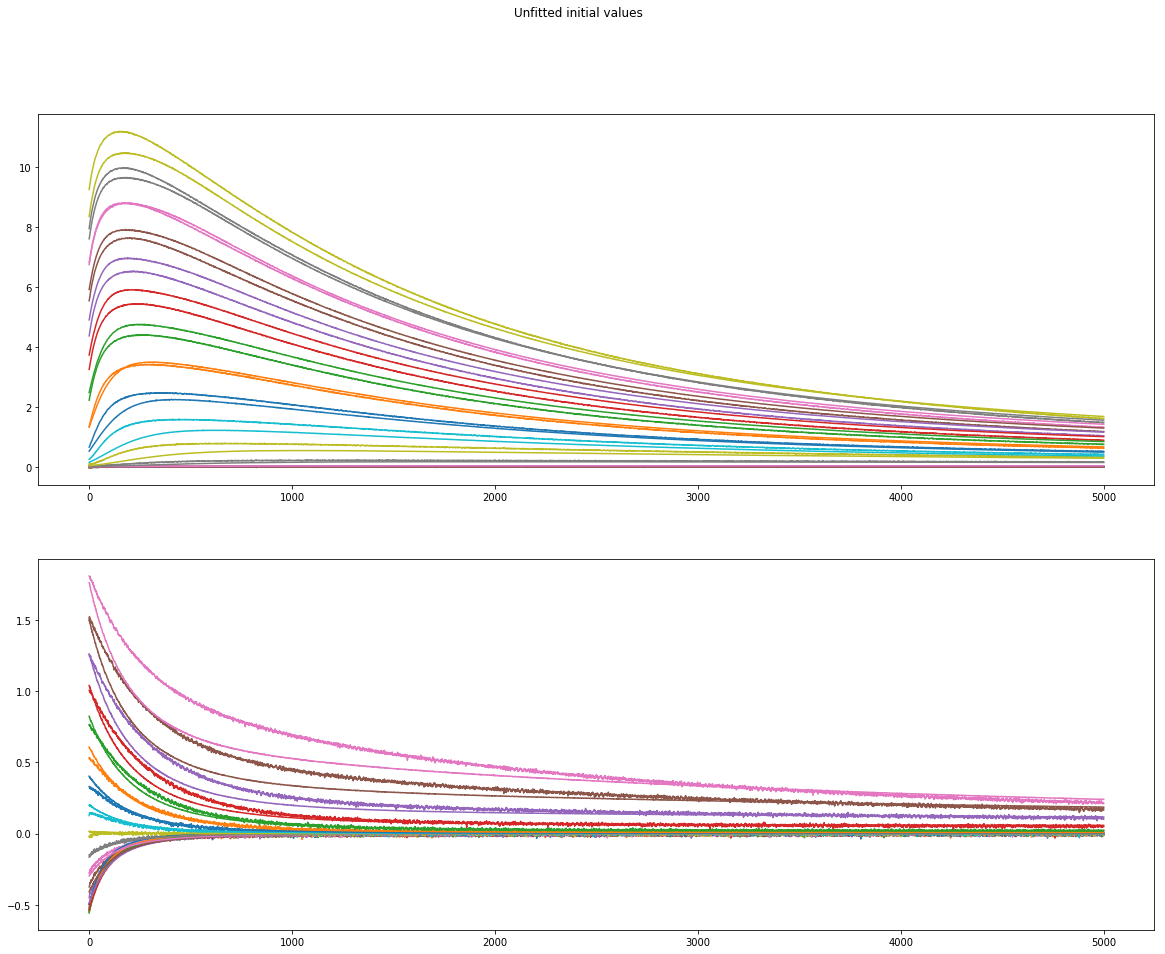

In [17]:
# Sanity check
I1, I2 = currents(ana[0], get_hold_voltages(ana[0]), pA)
I1_target, I2_target = get_targets(ana[0])

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
for I in I1_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I1:
    plt.plot(I)

plt.subplot(2,1,2)
for I in I2_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I2:
    plt.plot(I)
    
plt.suptitle("Unfitted initial values")

In [23]:
def residuals(p, a, hold_voltages, targets, current_fn):
    I1, I2 = current_fn(a, hold_voltages, p)
    
    # compare to target
    I1 -= targets[0]
    I2 -= targets[1]
    
    return np.concatenate((I1.ravel(), I2.ravel()))

In [24]:
fits = [0] * len(ana)
for i,a in enumerate(ana):
    hold_voltages = get_hold_voltages(a)
    targets = get_targets(a)
    
    start = time.time()
    fits[i] = scipy.optimize.least_squares(residuals, pA,
                                           args = (a, hold_voltages, targets, currents),
                                           bounds = ([-100, 0, 0,
                                                     -60, 12,               # ns [-50., 15.]
                                                     -70, -10, 0,           # hs [-60.,-7.,.08]
                                                     -60, 12,               # nf [-50., 15.]
                                                     -70, -10, 0,           # hf [-60.,-7.,.02]
                                                     1, 40, 80, 22, -25,    # tauns [4., 62., 85., 26., -20.]
                                                     80, 1e3, 65, 5,        # tauhs [120., 5e3, 72., 8.]
                                                     .5, 15, 60, 15, -40,   # taunf [1., 22., 65., 18., -32.]
                                                     25, 1e3, 65, 5         # tauhf [35., 5e3, 72., 7.]
                                                     ],
                                                     [-50, 0.05, 0.15,
                                                     -40, 18,               # ns
                                                     -50, -5, 0.12,         # hs
                                                     -40, 18,               # nf
                                                     -50, -5, 0.12,         # hf
                                                     10, 85, 90, 30, -15,   # tauns
                                                     160, 2e4, 80, 10,      # tauhs
                                                     2, 30, 70, 20, -25,    # taunf
                                                     50, 2e4, 80, 10        # tauhf
                                                     ]))
    print i, time.time() - start, fits[i].cost

0 14285.491884 188.420934180377


Text(0.5,0.98,'Fitted values, 31 DoF')

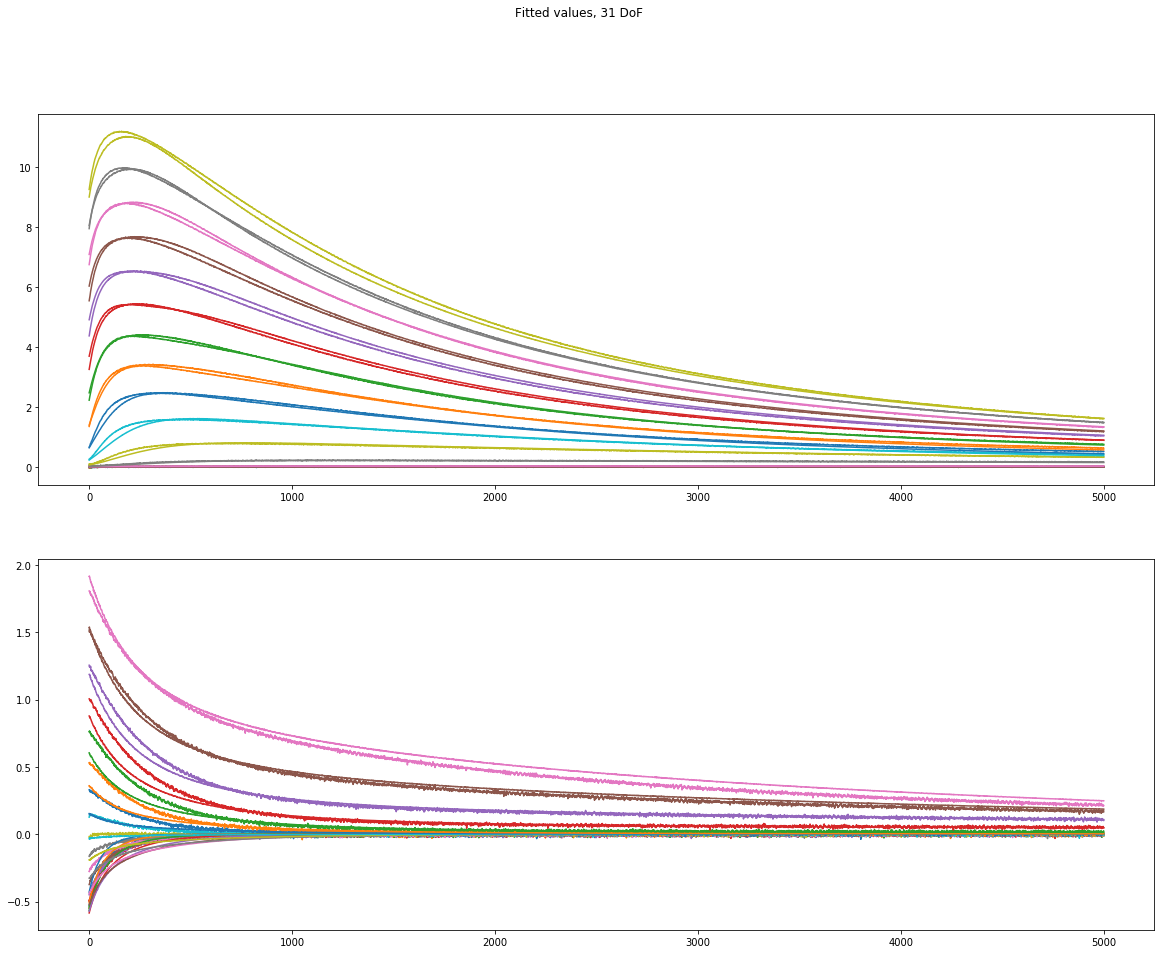

In [52]:
I1, I2 = currents(ana[0], get_hold_voltages(ana[0]), fits[0].x)
I1_target, I2_target = get_targets(ana[0])

plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
for I in I1_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I1:
    plt.plot(I)

plt.subplot(2,1,2)
for I in I2_target:
    plt.plot(I)
plt.gca().set_prop_cycle(None)
for I in I2:
    plt.plot(I)
    
plt.suptitle("Fitted values, 31 DoF")

In [42]:
def print_p31(p):
    print "E_K: %f, gslow: %f, gfast: %f" % tuple(p[0:3])
    print "n_slow off, slope:\t\t %f, %f" % tuple(p[3:5])
    print "h_slow off, slope, noninact:\t %f, %f, %f" % tuple(p[5:8])
    print "n_fast off, slope:\t\t %f, %f" % tuple(p[8:10])
    print "h_fast off, slope, noninact:\t %f, %f, %f" % tuple(p[10:13])
    print "tau n slow min, max, off, slopes:\t %f, %f, %f, %f, %f" % tuple(p[13:18])
    print "tau h slow min, max, off, slope:\t %f, %f, %f, %f" % tuple(p[18:22])
    print "tau n fast min, max, off, slopes:\t %f, %f, %f, %f, %f" % tuple(p[22:27])
    print "tau h fast min, max, off, slope:\t %f, %f, %f, %f" % tuple(p[27:])

In [43]:
print_p31(fits[0].x)

E_K: -73.817950, gslow: 0.035583, gfast: 0.086322
n_slow off, slope:		 -44.337441, 17.788187
h_slow off, slope, noninact:	 -59.558127, -5.025656, 0.000406
n_fast off, slope:		 -44.272698, 17.846452
h_fast off, slope, noninact:	 -65.166781, -5.011572, 0.036876
tau n slow min, max, off, slopes:	 1.999743, 85.000000, 80.000000, 30.000000, -15.000000
tau h slow min, max, off, slope:	 92.969454, 18295.968393, 79.999977, 5.000000
tau n fast min, max, off, slopes:	 0.816877, 15.000000, 61.375268, 20.000000, -36.261602
tau h fast min, max, off, slope:	 32.609505, 1000.000017, 68.366358, 9.999999


In [49]:
def plot_p31(p):
    plt.subplot(4,2,1).set_ylabel(r'slow activation $n_\infty$')
    plt.subplot(4,2,2).set_ylabel(r'slow inactivation $h_\infty$')
    plt.subplot(4,2,3).set_ylabel(r'slow activation $\tau_n$ (ms)')
    plt.subplot(4,2,4).set_ylabel(r'slow inactivation $\tau_h$ (ms)')

    plt.subplot(4,2,5).set_ylabel(r'fast activation $n_\infty$')
    plt.subplot(4,2,6).set_ylabel(r'fast inactivation $h_\infty$')
    plt.subplot(4,2,7).set_ylabel(r'fast activation $\tau_n$ (ms)')
    plt.subplot(4,2,8).set_ylabel(r'fast inactivation $\tau_h$ (ms)')

    Vprobe = np.arange(-120,60)

    plt.subplot(4,2,1).plot(Vprobe, Kv14.sigmoid(p[3:5], Vprobe))
    #plt.ylim(0,1)
    plt.subplot(4,2,2).plot(Vprobe, Kv14.sigmoid_min(p[5:8], Vprobe))
    plt.subplot(4,2,3).plot(Vprobe, Kv14.taun(p[13:18], Vprobe))
    plt.subplot(4,2,4).semilogy(Vprobe, Kv14.tauh(p[18:22], Vprobe))

    plt.subplot(4, 2, 5).plot(Vprobe, Kv14.sigmoid(p[8:10], Vprobe))
    #plt.ylim(0,1)
    plt.subplot(4,2,6).plot(Vprobe, Kv14.sigmoid_min(p[10:13], Vprobe))
    plt.subplot(4,2,7).plot(Vprobe, Kv14.taun(p[22:27], Vprobe))
    plt.subplot(4,2,8).semilogy(Vprobe, Kv14.tauh(p[27:], Vprobe))

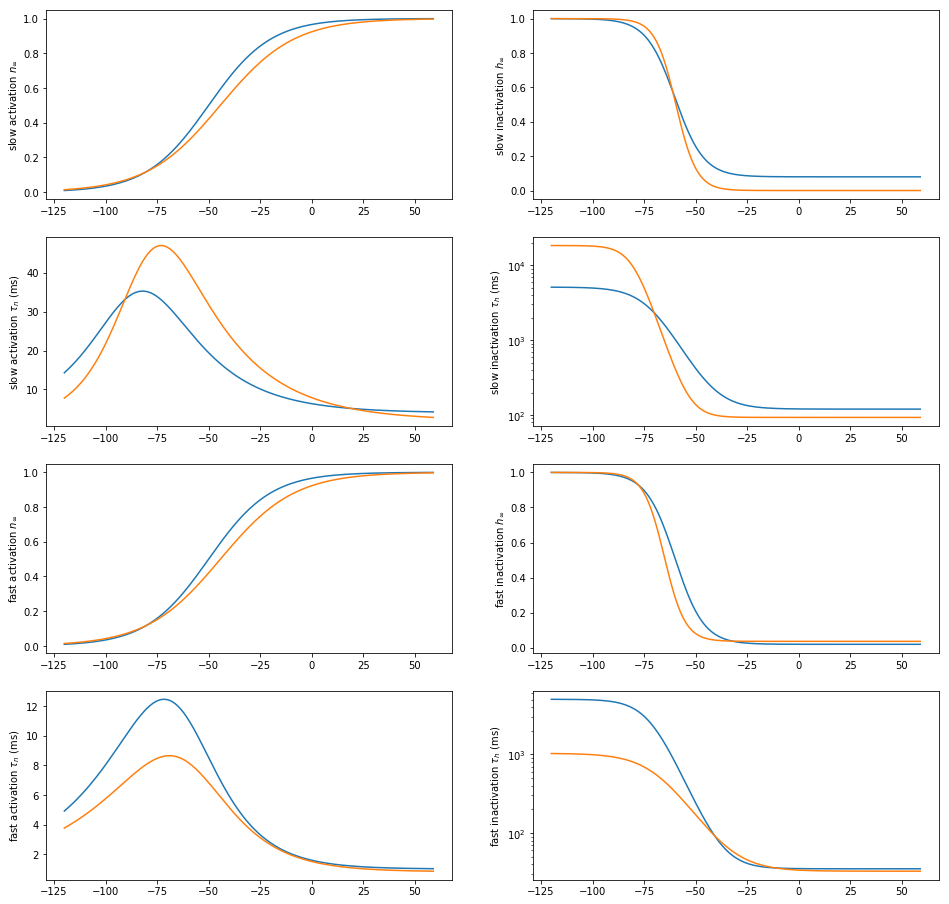

In [51]:
plt.figure(figsize=(16,16))
plot_p31(pA)
plot_p31(fits[0].x)

## Observation time!
* The full fit with 31 degrees of freedom takes some 4 hours with 5000 samples per trace; Kv2.1 will take longer, because the inactivation is slower, and thus I'll need a longer trace for a sensible fit.
* Slow and fast $n_{\infty}$ are fitted to almost exactly the same values, in a nice convergence with my earlier work, and strongly suggesting that it is the time course of activation, not its voltage sensitivity, that differs between the components
* Slow and fast $h_{\infty}$ differ somewhat, the fast component being shifted towards more negative potentials, but the difference, at 5 mV, is relatively minor. Both components fit to near the minimum boundary for the slope parameter.
* I should note that the two protocols I've used aren't very good at pulling out inactivation at the lower end of the voltage scale
* The noninactivating fractions are very low; it's entirely possible that I've mistaken insufficient leak compensation for noninactivation in my previous work, although others, too, have noted some resistance to inactivation
* To conclude my observations of the activation and inactivation fits, I think that from a modelling and fitting perspective it's reasonable to collapse these parameters into one, leaving only the time scales to differ between the two components.
* The time scales for the slow and fast components separate much more clearly than I would have expected, with the slow trending slower, and the fast trending faster, than my previous fit. Quite a few values are hugging the boundaries, however, so I'll try loosening them up some.

In [53]:
def current_components(a, hold_voltages, p):
    tmax, tblank, t2max, t2blank = get_limits(a)
    
    # Find hold states
    rec_hold_state = zip(*Kv14.state_at(10000, hold_voltages[0], (.5,.5,.5,.5), p[3:]))
    rec2_hold_state = zip(*Kv14.state_at(10000, hold_voltages[1], (.5,.5,.5,.5), p[3:]))
    
    # Populate the two-component HH states over the fitting period
    rec_states = np.zeros((len(a.rec.voltage), tmax, 4))
    for i, voltage, state in zip(range(len(a.rec.voltage)), a.rec.voltage, rec_hold_state):
        for t in range(tblank):
            V = voltage[Kv14.rec_step_t0 + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])

        for t in range(tmax):
            V = voltage[Kv14.rec_limits[0] + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])
            rec_states[i][t] = state
    
    rec2_states = np.zeros((len(a.rec2.voltage), t2max, 4))
    for i, voltage, state in zip(range(len(a.rec2.voltage)), a.rec2.voltage, rec2_hold_state):
        for t in range(Kv14.rec2_prepulse, Kv14.rec2_limits[0]):
            state = Kv14.state_at(Kv14.tres, voltage[t], state, p[3:])

        for t in range(t2blank):
            V = voltage[Kv14.rec2_limits[0] + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])

        for t in range(t2max):
            V = voltage[a.rec2.tail_cut + t]
            state = Kv14.state_at(Kv14.tres, V, state, p[3:])
            rec2_states[i][t] = state
    
    # Apply conductance to the states to compute the current components
    Irec_slow = np.reshape([(voltage[Kv14.rec_limits[0] + t] - p[0]) * p[1] * state[0]**4 * state[1]
                      for voltage, states in zip(a.rec.voltage, rec_states)
                      for t, state in enumerate(states)],
                     (len(a.rec.voltage), tmax))
    Irec_fast = np.reshape([(voltage[Kv14.rec_limits[0] + t] - p[0]) * p[2] * state[2]**4 * state[3]
                      for voltage, states in zip(a.rec.voltage, rec_states)
                      for t, state in enumerate(states)],
                     (len(a.rec.voltage), tmax))

    Irec2_slow = np.reshape([(voltage[a.rec2.tail_cut + t] - p[0]) * p[1] * state[0]**4 * state[1]
                       for voltage, states in zip(a.rec2.voltage, rec2_states)
                       for t, state in enumerate(states)],
                      (len(a.rec2.voltage), t2max))
    Irec2_fast = np.reshape([(voltage[a.rec2.tail_cut + t] - p[0]) * p[2] * state[2]**4 * state[3]
                       for voltage, states in zip(a.rec2.voltage, rec2_states)
                       for t, state in enumerate(states)],
                      (len(a.rec2.voltage), t2max))
    
    return Irec_slow, Irec_fast, Irec2_slow, Irec2_fast

Text(0.5,0.98,'Fitted values, 31 DoF, separated components')

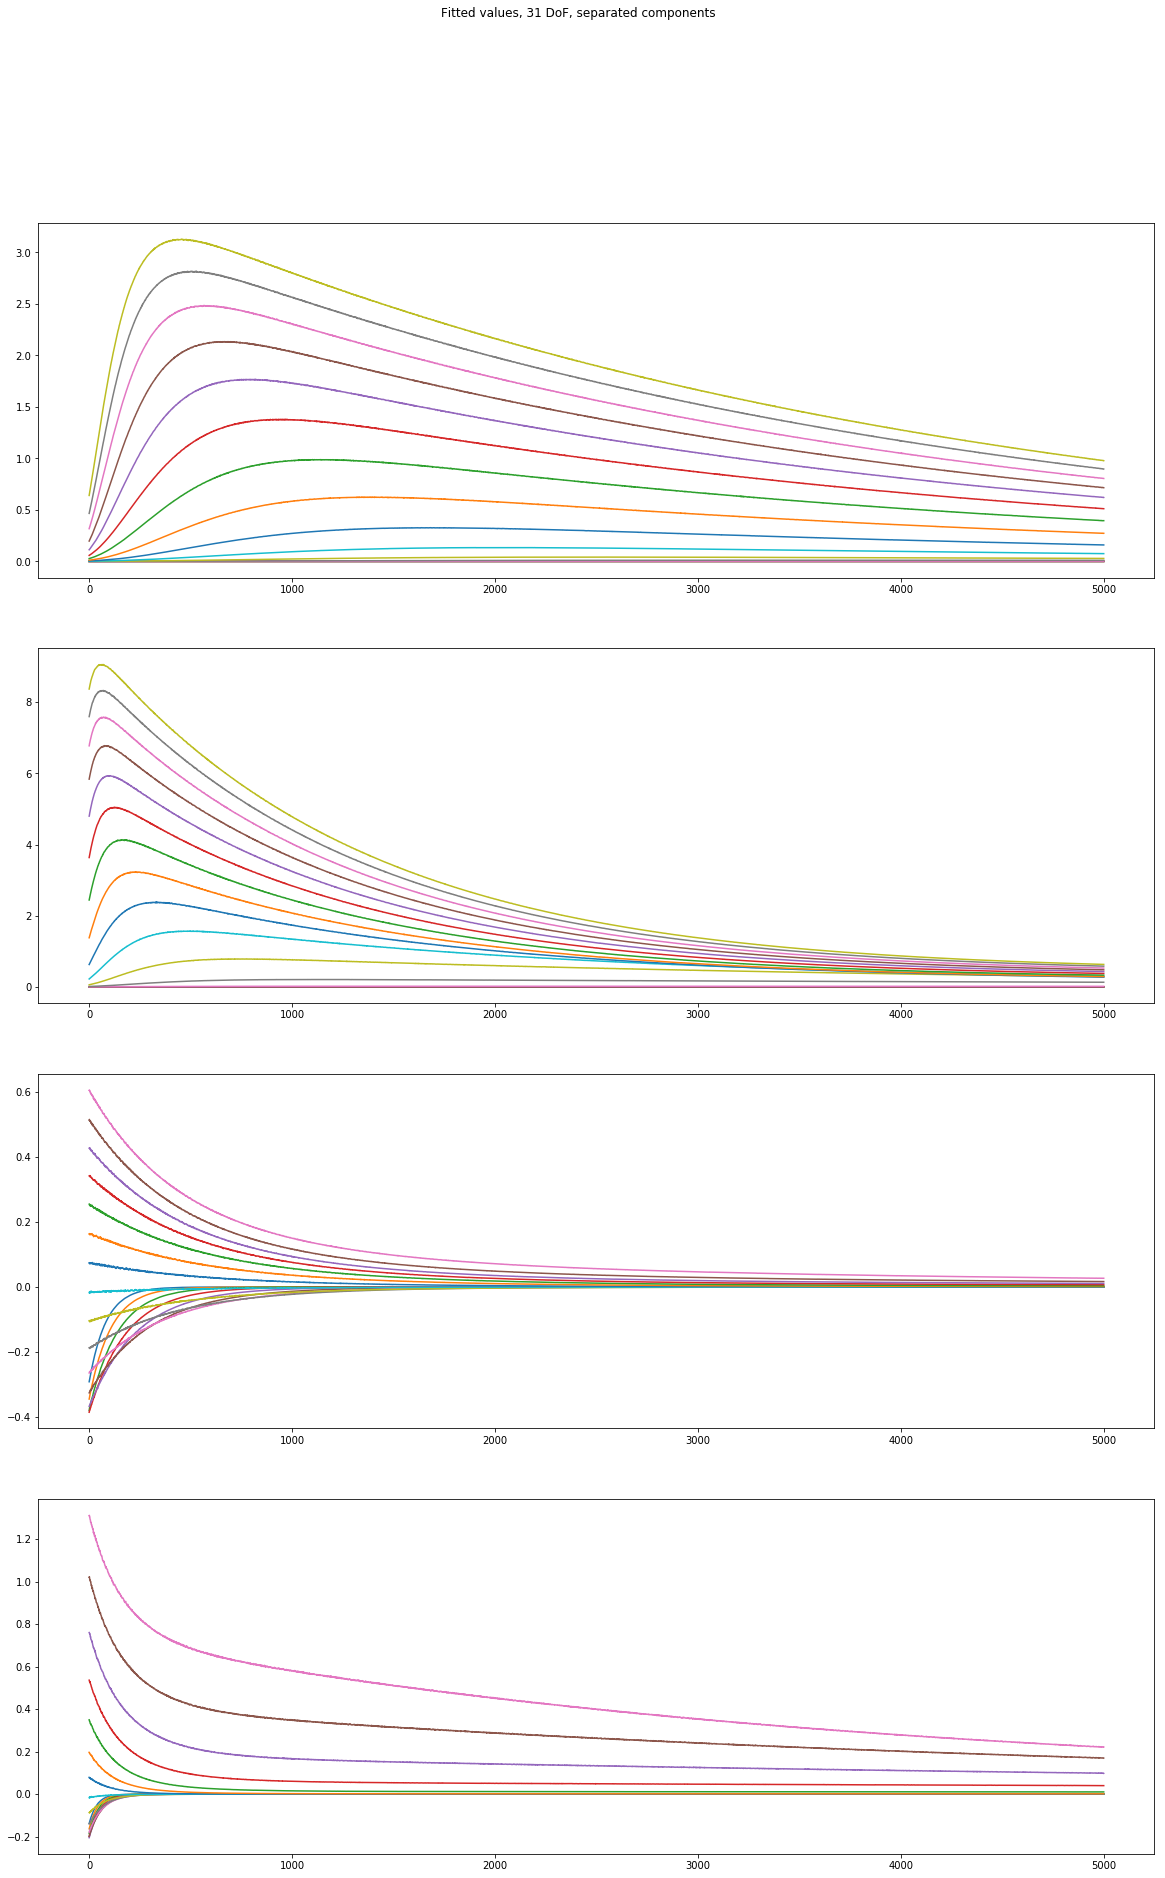

In [54]:
I1s, I1f, I2s, I2f = current_components(ana[0], get_hold_voltages(ana[0]), fits[0].x)

plt.figure(figsize=(20,30))
plt.subplot(4,1,1)
for I in I1s:
    plt.plot(I)

plt.subplot(4,1,2)
for I in I1f:
    plt.plot(I)
    
plt.subplot(4,1,3)
for I in I2s:
    plt.plot(I)

plt.subplot(4,1,4)
for I in I2f:
    plt.plot(I)
    
plt.suptitle("Fitted values, 31 DoF, separated components")

In [61]:
%store fits

Stored 'fits' (list)
